In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
fromsklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Load dataset
data = load_breast_cancer()
X = data.data          # features
y = data.target        # labels
feature_names = data.feature_names

# Normalize features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Data shape:", X_scaled.shape)
print("Target shape:", y.shape)


Data shape: (569, 30)
Target shape: (569,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 398
Test samples: 171


Training accuracy: 0.9799
Test accuracy: 0.9825


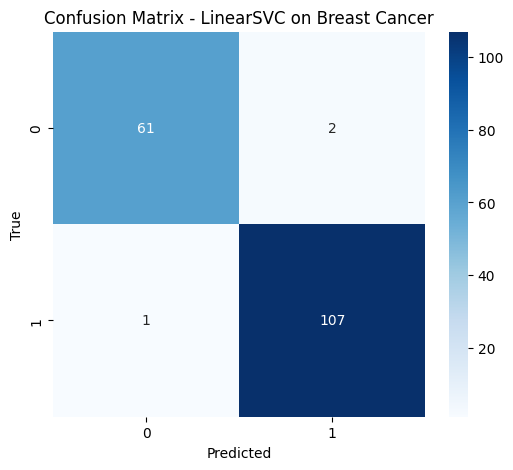

In [4]:
# LinearSVC can need more iterations for convergence
model = LinearSVC(random_state=42, max_iter=10000)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LinearSVC on Breast Cancer')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [5]:
n_features = X_scaled.shape[1]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

selected_features_forward = []
remaining_features = list(range(n_features))
forward_scores = []

print("\n--- Forward Greedy Feature Selection ---")
for _ in range(n_features):
    best_score = 0
    best_feature = None
    for f in remaining_features:
        features_to_try = selected_features_forward + [f]
        model = LinearSVC(max_iter=10000, random_state=42)
        scores = cross_val_score(model, X_scaled[:, features_to_try], y, cv=kf)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_feature = f
    selected_features_forward.append(best_feature)
    remaining_features.remove(best_feature)
    forward_scores.append(best_score)
    print(f"Step {_+1}: add feature {feature_names[best_feature]}, CV accuracy = {best_score:.4f}")



--- Forward Greedy Feature Selection ---
Step 1: add feature worst perimeter, CV accuracy = 0.9174
Step 2: add feature worst smoothness, CV accuracy = 0.9578
Step 3: add feature worst texture, CV accuracy = 0.9701
Step 4: add feature mean area, CV accuracy = 0.9736
Step 5: add feature worst area, CV accuracy = 0.9753
Step 6: add feature concavity error, CV accuracy = 0.9771
Step 7: add feature fractal dimension error, CV accuracy = 0.9771
Step 8: add feature worst radius, CV accuracy = 0.9771
Step 9: add feature mean texture, CV accuracy = 0.9771
Step 10: add feature smoothness error, CV accuracy = 0.9771
Step 11: add feature mean radius, CV accuracy = 0.9771
Step 12: add feature radius error, CV accuracy = 0.9771
Step 13: add feature concave points error, CV accuracy = 0.9771
Step 14: add feature area error, CV accuracy = 0.9771
Step 15: add feature mean perimeter, CV accuracy = 0.9754
Step 16: add feature perimeter error, CV accuracy = 0.9754
Step 17: add feature texture error, CV a

In [14]:
selected_features_backward = list(range(n_features))
backward_scores = []
removed_features = []

for _ in range(n_features-1):
    best_score = 0
    worst_feature = None
    for f in selected_features_backward:
        features_to_try = [feat for feat in selected_features_backward if feat != f]
        model = LinearSVC(max_iter=10000, random_state=42)
        scores = cross_val_score(model, X_scaled[:, features_to_try], y, cv=kf)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            worst_feature = f
    selected_features_backward.remove(worst_feature)
    removed_features.append(worst_feature)
    backward_scores.append(best_score)
    print(f"Step {_+1}: remove feature {feature_names[worst_feature]}, CV accuracy = {best_score:.4f}")
top6_backward = [f for f in range(n_features) if f not in removed_features[:n_features-6]]
print("Top 6 features (Backward Selection):", feature_names[top6_backward])


Step 1: remove feature mean concavity, CV accuracy = 0.9789
Step 2: remove feature radius error, CV accuracy = 0.9807
Step 3: remove feature mean radius, CV accuracy = 0.9807
Step 4: remove feature mean perimeter, CV accuracy = 0.9807
Step 5: remove feature mean area, CV accuracy = 0.9807
Step 6: remove feature mean smoothness, CV accuracy = 0.9807
Step 7: remove feature mean compactness, CV accuracy = 0.9807
Step 8: remove feature mean symmetry, CV accuracy = 0.9807
Step 9: remove feature worst fractal dimension, CV accuracy = 0.9825
Step 10: remove feature texture error, CV accuracy = 0.9825
Step 11: remove feature area error, CV accuracy = 0.9825
Step 12: remove feature smoothness error, CV accuracy = 0.9825
Step 13: remove feature concavity error, CV accuracy = 0.9825
Step 14: remove feature concave points error, CV accuracy = 0.9825
Step 15: remove feature compactness error, CV accuracy = 0.9825
Step 16: remove feature perimeter error, CV accuracy = 0.9825
Step 17: remove feature 

In [15]:
top6_forward = selected_features_forward[:6]


print("\nTop 6 features (Forward Selection):", feature_names[top6_forward])
print("Top 6 features (Backward Selection):", feature_names[top6_backward])



Top 6 features (Forward Selection): ['worst perimeter' 'worst smoothness' 'worst texture' 'mean area'
 'worst area' 'concavity error']
Top 6 features (Backward Selection): ['mean texture' 'mean concave points' 'mean fractal dimension'
 'worst perimeter' 'worst smoothness' 'worst symmetry']


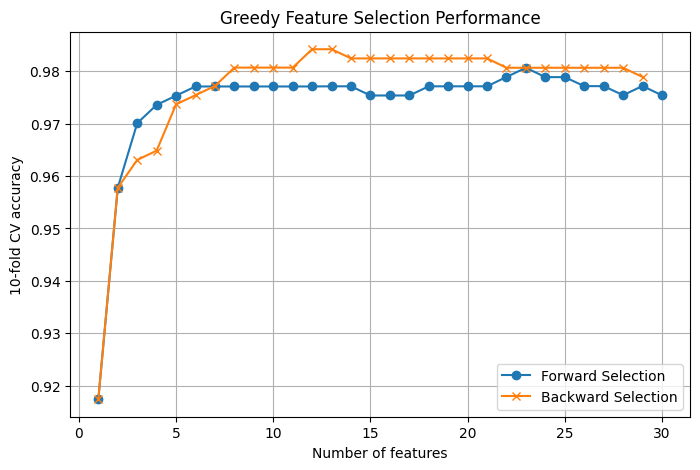

In [8]:
plt.figure(figsize=(8,5))
plt.plot(range(1, n_features+1), forward_scores, marker='o', label='Forward Selection')
plt.plot(range(n_features-1, 0, -1), backward_scores, marker='x', label='Backward Selection')
plt.xlabel('Number of features')
plt.ylabel('10-fold CV accuracy')
plt.title('Greedy Feature Selection Performance')
plt.legend()
plt.grid(True)
plt.show()
